## 3.1 MINST

In [9]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

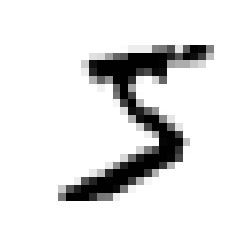

In [6]:
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) #샘플의 특성 벡터를 추출해서 28x28 배열로 reshape

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [7]:
# 실제 레이블 확인
y[0]

'5'

In [19]:
# 레이블은 문자열(str) -> 숫자로 변경
y = y.astype(np.int8)

In [20]:
# 데이터 확인 전 테스트 띄어놓기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

### 1) 5만 식별해보기 -> 5인것, 아닌 것 이진분류기

In [21]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [22]:
# SGDClassifier로 분류하기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
# some_digit(5) 분류 해보기
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 분류기는 회귀모델보다 사용 가능 지표가 많아서 복잡함

## 3.3.1 교차 검증을 사용한 정확도 측정

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [29]:
# cross_val_score로 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### = 3번의 교차 검증 모두 정확도 95이상

In [31]:
# 모든 이미지를 '5 아님'으로 분류하는 더미 분류기 만들어 비교
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [32]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### = 정확도 90% 이상 / 이미지의 10%가 5이므로 무조건 '5 아님'으로 예측하면 90%는 맞는게 정상

### ∴ acc를 분류 모델 성능 지표로 선호하지 않는 이유. 특히 불균형 데이터에 경우

## 3.3.2 오차 행렬(confusion matrix)

In [36]:
# 오차 행렬 생성 위한 예측값 생성
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [39]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류 예시
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 3.3.3 정밀도(precision)과 재현율(recall)

In [45]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

### F1-score(정밀도와 재현율의 조화평균) : 두 분류기 비교시 편리

In [48]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

## 3.3.4 정밀도와 재현율의 tradi-off관계(반비례)

In [50]:
# cross_val_predict의 옵션을 decision_function(결정 점수)를 반환하도록 지정
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [51]:
#모든 임계값에 대해 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

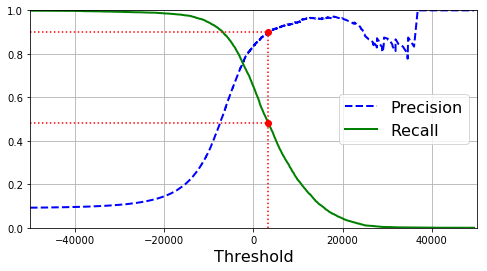

In [53]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
# save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

## 3.3.5 ROC곡선 : recall에 대한 1-특이도

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

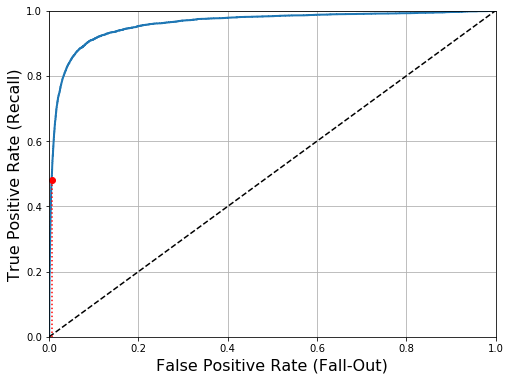

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [59]:
# ACU면접 비교를 통한 분류기 비교 -> 0.5~1사이 / 1에 가까울수록 좋음
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [61]:
# RandomForestClassifier를 훈련시켜 SGDClassifier와 비교
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [63]:
y_scores_forest = y_proba_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

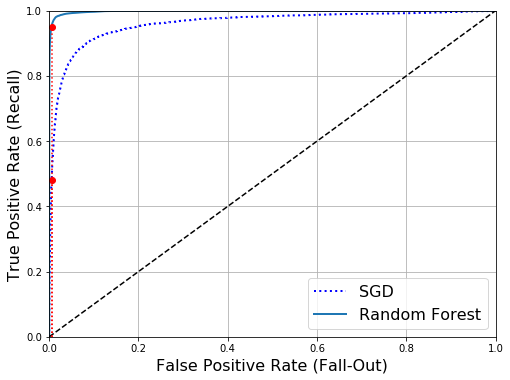

In [64]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

### ∴ RF 분류기가 sgd보다 좋은 것 확인

## 3.4 다중분류

In [67]:
#OvO 사용()
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=int8)

In [68]:
# 제일 높은 점수가 클래스 5dp goekd
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

## 3.5. 에러 분석 : scale이 너무 오래 걸려서 코딩 생략

## 3.6 다중 레이블 분류

In [71]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [72]:
knn_clf.predict([some_digit])

array([[False,  True]])

### = 숫자 5는 7보다 크지 않고, 홀수다 -> 맞게 분류

## 3.7 다중 출력 분류

In [75]:
# mnist 이미지에 randint로 픽셀 강도 잡음 추가 / 타깃 이미지는 원본 이미지
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [77]:
# 테스트에서 샘플 확인 -> 이러면 안 됨
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'plot_digit' is not defined